# Title of your assignment

#### Student no : 21627725
#### Student name : Oktay UĞURLU



The necessary libraries are imported here for this assignment.

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.ml.clustering import KMeans

import findspark
import pyspark
from pyspark import SparkContext, SparkConf     # libraries for spark
from pyspark.sql import SparkSession
 
pd.options.display.max_columns = None

from pyspark.ml.feature import MinMaxScaler       # min max scaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import *

%matplotlib inline
import matplotlib.pyplot as plt                              #For visualization
import seaborn as sns; sns.set()
import copy

from pyspark.ml.classification import LogisticRegression     # Classification model
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier


from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix                # For evaluation
import operator

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Table of Content

[Purpose](#purpose)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling for Clustering](#clusteringmodel)  
[Clustering results](#clustering)    
[Modeling for Classification](#classificationmodel)  
[Evaluation](#evaluation)  
[References](#references)   


## Purpose <a class="anchor" id="purpose"></a>

In this assignment, we will try to predict the diagnosis of some patients who may have breast cancer by using pyspark MLLib library, and we will try to classify their data by using clustering method. While doing this, we also compare the affects of normalization on the results of classification and clustering methods.

## Data Understanding<a class="anchor" id="data_understanding"></a>

Spark session is created.

In [0]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

Our data is imported as pyspark dataframe.

In [6]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data (1).csv


In [0]:
df_csv = spark.read.format("csv").option("header", "true").load("data.csv")

In here, we can see the number of rows in the pyspark dataframe. There is 569 row in the dataframe.

In [8]:
df_csv.count()

569

As we can see below, there is no null value in table if we compare with the below result as you can see above. All columns have same number of rows which is not null and 569. The range of the fields are not same and not scaled according to each other.

In [9]:
from pyspark.sql.functions import first

df_csv.describe().show() 

+-------+--------------------+---------+------------------+-----------------+-----------------+-----------------+--------------------+-------------------+-------------------+--------------------+--------------------+----------------------+------------------+------------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+--------------------+-------------------+-------------------+--------------------+-------------------+-----------------------+----+
|summary|                  id|diagnosis|       radius_mean|     texture_mean|   perimeter_mean|        area_mean|     smoothness_mean|   compactness_mean|     concavity_mean| concave points_mean|       symmetry_mean|fractal_dimension_mean|         radius_se|        texture_se|      perimeter_se|          area_se|       smoothness_se|      compactness_

When we look at the columns of data, we can see that all these are string value.

In [10]:
df_csv.printSchema()

root
 |-- id: string (nullable = true)
 |-- diagnosis: string (nullable = true)
 |-- radius_mean: string (nullable = true)
 |-- texture_mean: string (nullable = true)
 |-- perimeter_mean: string (nullable = true)
 |-- area_mean: string (nullable = true)
 |-- smoothness_mean: string (nullable = true)
 |-- compactness_mean: string (nullable = true)
 |-- concavity_mean: string (nullable = true)
 |-- concave points_mean: string (nullable = true)
 |-- symmetry_mean: string (nullable = true)
 |-- fractal_dimension_mean: string (nullable = true)
 |-- radius_se: string (nullable = true)
 |-- texture_se: string (nullable = true)
 |-- perimeter_se: string (nullable = true)
 |-- area_se: string (nullable = true)
 |-- smoothness_se: string (nullable = true)
 |-- compactness_se: string (nullable = true)
 |-- concavity_se: string (nullable = true)
 |-- concave points_se: string (nullable = true)
 |-- symmetry_se: string (nullable = true)
 |-- fractal_dimension_se: string (nullable = true)
 |-- radiu

You can see number of beign and malignants as you can see below with bar plot. Number of malignants are 212 and number of beigns are 357.

In [11]:
df = df_csv.groupby('diagnosis')
df = df.count().show()

+---------+-----+
|diagnosis|count|
+---------+-----+
|        B|  357|
|        M|  212|
+---------+-----+



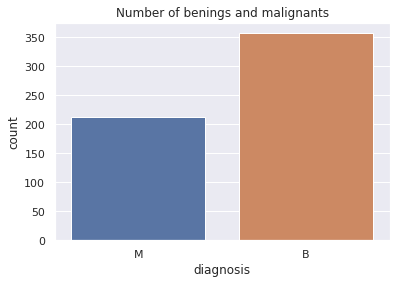

In [12]:
df_for_barchart = df_csv.toPandas()
ax = sns.countplot(df_for_barchart.iloc[:,1]).set_title("Number of benings and malignants") 

## Data Preparation<a class="anchor" id="data_preparation"></a>

Firstly we need to drop the unnecessary columns which are id and _c32. The id column is to identify the rows, so it is reduntant column. Also, c_32 column has all null value. Thus, we drop these first.

In [0]:
df_prepared = df_csv.drop('_c32')
df_prepared = df_csv.drop('id')

In here, diagnosis column is turned to diagnosis_B. If diagnosis_B is equal to 1, it means benign.

In [0]:
def turn_dummy(value):
  if   value == 'B': 
      return 1
  else:
      return 0 
    
udf_turn_dummy = udf(turn_dummy, StringType())
df_dummies = df_prepared.withColumn("diagnosis_B", udf_turn_dummy("diagnosis"))
df_dummies = df_dummies.drop("diagnosis")

df_dummies = df_dummies.withColumn("diagnosis_B_float", F.col("diagnosis_B").cast(DoubleType()))
df_dummies = df_dummies.drop("diagnosis_B")
df_dummies = df_dummies.withColumn("diagnosis_B", F.col("diagnosis_B_float"))
df_dummies = df_dummies.drop("diagnosis_B_float")
df_dummies = df_dummies.drop('_c32')
#df_dummies.printSchema()

In [15]:
df_dummies.printSchema()

root
 |-- radius_mean: string (nullable = true)
 |-- texture_mean: string (nullable = true)
 |-- perimeter_mean: string (nullable = true)
 |-- area_mean: string (nullable = true)
 |-- smoothness_mean: string (nullable = true)
 |-- compactness_mean: string (nullable = true)
 |-- concavity_mean: string (nullable = true)
 |-- concave points_mean: string (nullable = true)
 |-- symmetry_mean: string (nullable = true)
 |-- fractal_dimension_mean: string (nullable = true)
 |-- radius_se: string (nullable = true)
 |-- texture_se: string (nullable = true)
 |-- perimeter_se: string (nullable = true)
 |-- area_se: string (nullable = true)
 |-- smoothness_se: string (nullable = true)
 |-- compactness_se: string (nullable = true)
 |-- concavity_se: string (nullable = true)
 |-- concave points_se: string (nullable = true)
 |-- symmetry_se: string (nullable = true)
 |-- fractal_dimension_se: string (nullable = true)
 |-- radius_worst: string (nullable = true)
 |-- texture_worst: string (nullable = tr

All fields are converted to double type.

In [0]:
from pyspark.sql.functions import col

column_names_list = df_dummies.schema.names

for i in column_names_list:
  df_dummies = df_dummies.withColumn(i, col(i).cast(DoubleType()))

In this part, the data is splitted as normalized_data and original_data to apply the same modeling on the different dataand to see the differences between normalized data and original data.

In [0]:
normalized_data = df_dummies
original_data = df_dummies

The features are scaled in 0 to 1 by using min-max scaled.

In [0]:
column_names_list_normalized = normalized_data.schema.names
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in column_names_list_normalized]
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in column_names_list_normalized]
pipeline = Pipeline(stages=assemblers + scalers)
scaler_model = pipeline.fit(normalized_data)
normalized_data = scaler_model.transform(normalized_data)

unlist = udf(lambda x: float(list(x)[0]), DoubleType())
for i in column_names_list_normalized:
    normalized_data = normalized_data.drop(i)
    normalized_data = normalized_data.drop(i+'_vec')
    normalized_data = normalized_data.withColumn(i, unlist(i+"_scaled"))
    normalized_data = normalized_data.drop(i+'_scaled')

## Modeling for Clustering <a class="anchor" id="clusteringmodel"></a>

In this part, the normalized and original data is clustered by using K-means algorithm and evaluated their results. As a parameter, all fields of data is used except diagnosis_M field because it is already define actual clusters.

### 1) Normalized Data

We select for evaluation which is **K-means** algorithm to cluster **normalized data** into 2 cluster and evaluate after with the actual class which is diagnosis field. All fields are selected as parameter except **diagnosis_B**.

In [19]:
vecAssembler = VectorAssembler(inputCols=column_names_list_normalized[:-1], outputCol="features")
df_kmeans = vecAssembler.transform(normalized_data.drop('diagnosis_B')).select('features')
 

#K-means
kmeans = KMeans().setK(2).setSeed(1).setFeaturesCol("features")
model_normalized = kmeans.fit(df_kmeans)
transformed_normalized = model_normalized.transform(df_kmeans).select('prediction') 

cost = model_normalized.computeCost(df_kmeans)
print("Within Set Sum of Squared Errors For K-means = " + str(cost))

Within Set Sum of Squared Errors For K-means = 215.8383197204484


As you can see above, the sum of squared errors for K- means is 215 with normalized data.

### 2) Original Data

We select for evaluation which is **K-means** algorithm to cluster **original data** into 2 cluster and evaluate after with the actual class which is diagnosis field. All fields are selected as parameter except **diagnosis_B**.

In [20]:
column_names_list_original = original_data.schema.names
    
vecAssembler = VectorAssembler(inputCols=column_names_list_original[:-1], outputCol="features")
df_kmeans = vecAssembler.transform(original_data.drop('diagnosis_B')).select('features')
 

#K-means
kmeans = KMeans().setK(2).setSeed(1).setFeaturesCol("features")
model_original = kmeans.fit(df_kmeans)
transformed_original = model_original.transform(df_kmeans).select('prediction') 

cost = model_original.computeCost(df_kmeans)
print("Within Set Sum of Squared Errors For K-means = " + str(cost))

Within Set Sum of Squared Errors For K-means = 77943099.87829868


The set of squared errors for K-means is equal to 77943099 which is bigger than the results of normalized data. It means that the original data is not clustered in good order.

## Clustering results<a class="anchor" id="clustering"></a>

The data is transformed to Pandas dataframe for visualization by matplotlib and seaborn library. 

### 1) Normalized Data

We can see the 2 clusters by looking at the distribution of data of 2 different fields. Also by comparing the actual cluster's distribution on scatter plot which is the diagnosis, we can see the number of clusters is near to real. 

Text(0.5, 1.0, 'Predicted')

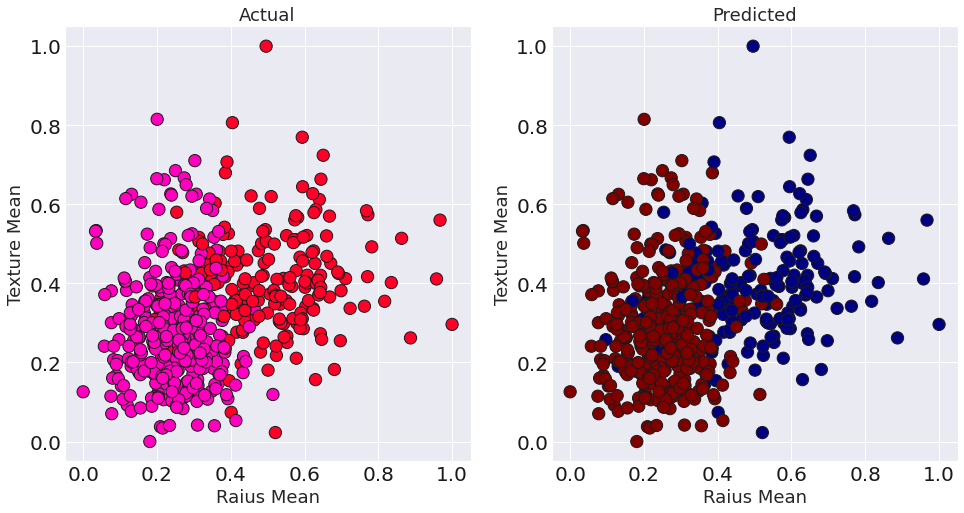

In [21]:
column_names_list_normalized = normalized_data.schema.names

fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].scatter(normalized_data.select('radius_mean').toPandas()['radius_mean'], normalized_data.select('texture_mean').toPandas()['texture_mean'], c=normalized_data.select('diagnosis_B').toPandas()['diagnosis_B'], cmap='gist_rainbow', edgecolor='k', s=150)
axes[1].scatter(normalized_data.select('radius_mean').toPandas()['radius_mean'], normalized_data.select('texture_mean').toPandas()['texture_mean'], c=transformed_normalized.toPandas()['prediction'], cmap='jet', edgecolor='k', s=150)
axes[0].set_xlabel('Raius Mean', fontsize=18)
axes[0].set_ylabel('Texture Mean', fontsize=18)
axes[1].set_xlabel('Raius Mean', fontsize=18)
axes[1].set_ylabel('Texture Mean', fontsize=18)
axes[0].tick_params(direction='in', length=10, width=5, colors='k', labelsize=20)
axes[1].tick_params(direction='in', length=10, width=5, colors='k', labelsize=20)
axes[0].set_title('Actual', fontsize=18)
axes[1].set_title('Predicted', fontsize=18)

Ratio of predicted clusters are 66.8% and 33.2% for normalized data and the diagnosis are 62.7% and 37.3%. Our predicted results almost near to real one.

(-1.1139688234527358,
 1.100665182069178,
 -1.1124743700812267,
 1.1205773936977308)

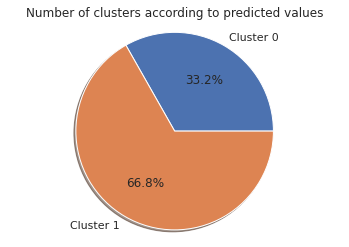

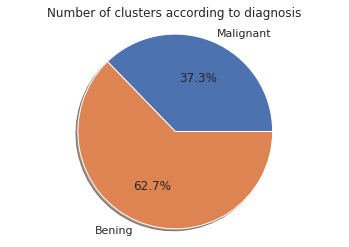

In [22]:
prediction_pd = transformed_normalized.toPandas()
normalized_pd = normalized_data.toPandas() 

plt.figure(0) 
plt.title('Number of clusters according to predicted values')
plt.pie([prediction_pd['prediction'][prediction_pd['prediction']==0.0].count(), prediction_pd['prediction'][prediction_pd['prediction']==1.0].count()],labels=['Cluster 0', 'Cluster 1'], autopct='%1.1f%%', shadow=True)
plt.axis('equal')

plt.figure(1)
plt.title('Number of clusters according to diagnosis')
plt.pie([normalized_pd['diagnosis_B'][normalized_pd['diagnosis_B']==0.0].count(), normalized_pd['diagnosis_B'][normalized_pd['diagnosis_B']==1.0].count()],labels=['Malignant', 'Bening'], autopct='%1.1f%%', shadow=True)
plt.axis('equal') 

### 2) Original Data

When we look at the distribution of clusters for original data, we can observe the distribution is not well as the normalized data.

Text(0.5, 1.0, 'Predicted')

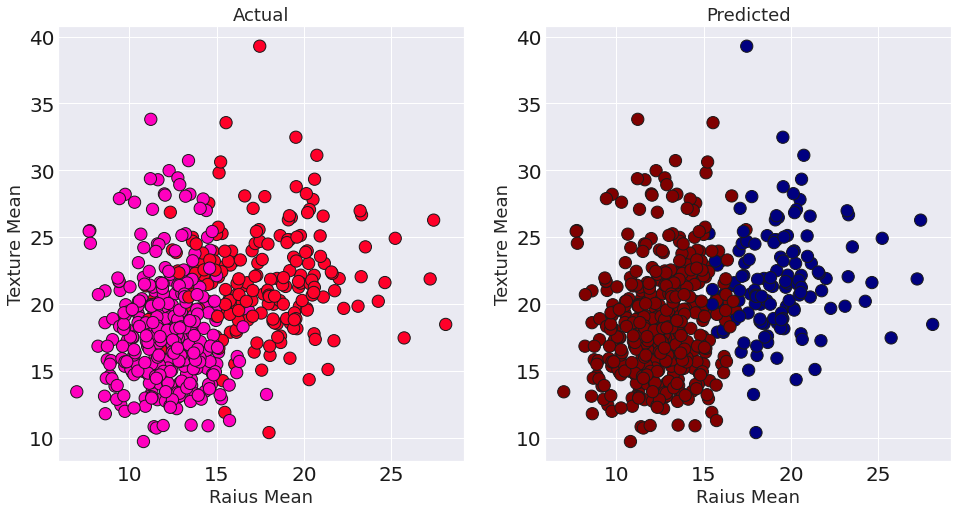

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].scatter(original_data.select('radius_mean').toPandas()['radius_mean'], original_data.select('texture_mean').toPandas()['texture_mean'], c=original_data.select('diagnosis_B').toPandas()['diagnosis_B'], cmap='gist_rainbow', edgecolor='k', s=150)
axes[1].scatter(original_data.select('radius_mean').toPandas()['radius_mean'], original_data.select('texture_mean').toPandas()['texture_mean'], c=transformed_original.toPandas()['prediction'], cmap='jet', edgecolor='k', s=150)
axes[0].set_xlabel('Raius Mean', fontsize=18)
axes[0].set_ylabel('Texture Mean', fontsize=18)
axes[1].set_xlabel('Raius Mean', fontsize=18)
axes[1].set_ylabel('Texture Mean', fontsize=18)
axes[0].tick_params(direction='in', length=10, width=5, colors='k', labelsize=20)
axes[1].tick_params(direction='in', length=10, width=5, colors='k', labelsize=20)
axes[0].set_title('Actual', fontsize=18)
axes[1].set_title('Predicted', fontsize=18)

If we look at pie charts to see better, for original data, ratio of clusters are 77.0% and 23.0% and the actual 2 diagnosis ratio are 62.7% and 37.3%. These numbers are not so much away from the real ones but worst than normalized data.

(-1.1139688234527358,
 1.100665182069178,
 -1.1124743700812267,
 1.1205773936977308)

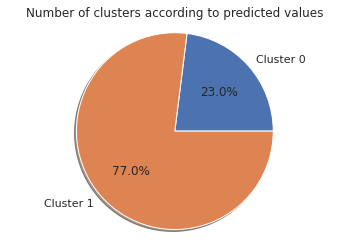

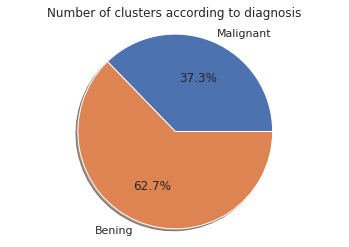

In [24]:
prediction_pd = transformed_original.toPandas()
original_pd = original_data.toPandas() 

plt.figure(0) 
plt.title('Number of clusters according to predicted values')
plt.pie([prediction_pd['prediction'][prediction_pd['prediction']==0.0].count(), prediction_pd['prediction'][prediction_pd['prediction']==1.0].count()],labels=['Cluster 0', 'Cluster 1'], autopct='%1.1f%%', shadow=True)
plt.axis('equal')

plt.figure(1)
plt.title('Number of clusters according to diagnosis')
plt.pie([original_pd['diagnosis_B'][original_pd['diagnosis_B']==0.0].count(), original_pd['diagnosis_B'][original_pd['diagnosis_B']==1.0].count()],labels=['Malignant', 'Bening'], autopct='%1.1f%%', shadow=True)
plt.axis('equal') 

These results imply that the normalization of the data makes the clustering model is better. Because, we use the K-means algorithm and here, the range affects the results of clustering. So, not fixed range fields are not good for clustering.


## Modeling for Classification <a class="anchor" id="classificationmodel"></a>

After splitting data, all normalized and original data is trained exactly in the same way after evaluate the differences.

### 1) Normalized Data

The features are transformed to Vector and create one feature for each row and prepared for modeling as by using StringIndexer() and VectorIndexer(). This operations are necessary when using MLlib modeling functions.

In [0]:
normalized_transformed = normalized_data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])
normalized_label_indexer = StringIndexer(inputCol='label',outputCol='indexed_label').fit(normalized_transformed)
normalized_feature_indexer =VectorIndexer(inputCol="features", outputCol="indexed_features", maxCategories=4).fit(normalized_transformed)
label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel",labels=normalized_label_indexer.labels)

Here, the prepared data is split into testing and training data to prevent the model from having overfitting. So, number of test rows are 30% percent of all rows.

In [0]:
(normalized_training_data, normalized_test_data) = normalized_transformed.randomSplit([0.7, 0.3],seed=10)

Here, 4 different classification modeling algorithm is evaluated by looking at their test error. These are **Logistic Regression, Decision Tree Classifier, Random Forest Tree**, and **Gradient-Boosted Tree Classifier**. I coded a function to train and print the accuracy of each model.

In [27]:
model_list = [LogisticRegression(featuresCol='indexed_features', labelCol='indexed_label'), 
              DecisionTreeClassifier(featuresCol='indexed_features', labelCol='indexed_label'),
              GBTClassifier(featuresCol='indexed_features', labelCol='indexed_label')]

name_list = ['Logistic Regression','Decision Tree Classifier', 'Gradient-boosted Tree Classifier']
predictions_list_normalized = []

def evaluate_model():
    for i in range(0,3):
        cls = model_list[i]
        pipeline = Pipeline(stages=[normalized_label_indexer, normalized_feature_indexer, cls,label_converter])
        model = pipeline.fit(normalized_training_data)
        predictions = model.transform(normalized_test_data)
        evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="accuracy")
        accuracy = evaluator.evaluate(predictions)
        predictions_list_normalized.append(accuracy)
        print("Accuracy of "+name_list[i]+" = %g" % (accuracy))
        print("Test Error of "+name_list[i]+" = %g" % (1.0 - accuracy))
        print("------------------------------")

evaluate_model()

Accuracy of Logistic Regression = 0.976608
Test Error of Logistic Regression = 0.0233918
------------------------------
Accuracy of Decision Tree Classifier = 0.959064
Test Error of Decision Tree Classifier = 0.0409357
------------------------------
Accuracy of Gradient-boosted Tree Classifier = 0.953216
Test Error of Gradient-boosted Tree Classifier = 0.0467836
------------------------------


For **Random Forest Classifier**, all values are checked in range between 1 to 25.

In [28]:
score_dict = {}
for i in range(1,20):
    rf = RandomForestClassifier(labelCol="indexed_label", featuresCol="indexed_features", numTrees=i) 
    # Chain indexers and forest in a Pipeline
    pipeline = Pipeline(stages=[normalized_label_indexer, normalized_feature_indexer, rf, label_converter])
    # Train model.  This also runs the indexers.
    model = pipeline.fit(normalized_training_data)
    # Make predictions.
    predictions = model.transform(normalized_test_data)
    # Select (prediction, true label) and compute test error
    evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    score_dict[i] = accuracy
    print("for numTrees = "+str(i)+" : "+str(score_dict[i]))
    
key = max(score_dict.items(), key=operator.itemgetter(1))[0]
print("Best number of trees value: "+str(key))
print("Best accuracy: "+str(score_dict[key]*100)+"%")



for numTrees = 1 : 0.9590643274853801
for numTrees = 2 : 0.9649122807017544
for numTrees = 3 : 0.9590643274853801
for numTrees = 4 : 0.9649122807017544
for numTrees = 5 : 0.9707602339181286
for numTrees = 6 : 0.9649122807017544
for numTrees = 7 : 0.9649122807017544
for numTrees = 8 : 0.9590643274853801
for numTrees = 9 : 0.9824561403508771
for numTrees = 10 : 0.9883040935672515
for numTrees = 11 : 0.9590643274853801
for numTrees = 12 : 0.9766081871345029
for numTrees = 13 : 0.9824561403508771
for numTrees = 14 : 0.9883040935672515
for numTrees = 15 : 0.9824561403508771
for numTrees = 16 : 0.9707602339181286
for numTrees = 17 : 0.9883040935672515
for numTrees = 18 : 0.9707602339181286
for numTrees = 19 : 0.9883040935672515
Best number of trees value: 10
Best accuracy: 98.83040935672514%


After the evaluation of 4 different classification algorithm, accuracy of the **Logistic Regression** is equal to 97.66%, the **Decision Tree Classifier** is 95.90%, the **Gradient-boosted Tree** is 95.32%, and the **Random Forest Tree** is 98.83% which has best result (This value can be changed for random forest tree algorithm). Thus, I select this algorithm as a model.

In [29]:
rfc = RandomForestClassifier(featuresCol='indexed_features', labelCol='indexed_label', numTrees=key)
pipeline = Pipeline(stages=[normalized_label_indexer, normalized_feature_indexer, rfc,label_converter])
model = pipeline.fit(normalized_training_data)
predictions_normalized = model.transform(normalized_test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="accuracy")
accuracy_normalized = evaluator.evaluate(predictions_normalized)
print("Accuracy of Random Forest Tree with number of trees "+str(key)+" = " + str(accuracy_normalized*100)+"%")
print("Test Error of Random Forest Tree with number of trees "+str(key)+" = %g" % (1.0 - accuracy_normalized))

Accuracy of Random Forest Tree with number of trees 10 = 98.83040935672514%
Test Error of Random Forest Tree with number of trees 10 = 0.0116959


### 2) Original Data

I followed same path above. Firstly, create label and feature indexer to use in modeling part.

In [0]:
original_transformed = original_data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])
original_label_indexer = StringIndexer(inputCol='label',outputCol='indexed_label').fit(original_transformed)
original_feature_indexer =VectorIndexer(inputCol="features", outputCol="indexed_features", maxCategories=4).fit(original_transformed)
original_label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel",labels=original_label_indexer.labels)


And I split the data as a testing and training the same as in normalization part.

In [0]:
(original_training_data, original_test_data) = original_transformed.randomSplit([0.7, 0.3],seed=10)

Like in the modeling of normalizated data , 4 different classification modeling algorithm is evaluated by looking their test error. These are **Logistic Regression, Decision Tree Classifier, Random Forest Tree**, and **Gradient-Boosted Tree Classifier**.

In [32]:
model_list = [LogisticRegression(featuresCol='indexed_features', labelCol='indexed_label'), 
              DecisionTreeClassifier(featuresCol='indexed_features', labelCol='indexed_label'),
              GBTClassifier(featuresCol='indexed_features', labelCol='indexed_label')]

name_list = ['Logistic Regression','Decision Tree Classifier','Gradient-boosted Tree Classifier']
predictions_list_original = []

def evaluate_model():
    for i in range(0,3):
        cls = model_list[i]
        pipeline = Pipeline(stages=[original_label_indexer, original_feature_indexer, cls,original_label_converter])
        model = pipeline.fit(original_training_data)
        predictions = model.transform(original_test_data)
        evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="accuracy")
        accuracy = evaluator.evaluate(predictions)
        predictions_list_original.append(accuracy)
        print("Accuracy of "+name_list[i]+" = " + str(accuracy*100)+"%")
        print("Test Error of "+name_list[i]+" = %g" % (1.0 - accuracy))
        print("------------------------------")

evaluate_model()

Accuracy of Logistic Regression = 98.24561403508771%
Test Error of Logistic Regression = 0.0175439
------------------------------
Accuracy of Decision Tree Classifier = 95.90643274853801%
Test Error of Decision Tree Classifier = 0.0409357
------------------------------
Accuracy of Gradient-boosted Tree Classifier = 95.32163742690058%
Test Error of Gradient-boosted Tree Classifier = 0.0467836
------------------------------


Here, I tried to find the best accuracy for **Random Forest Tree** algorithm by trying each value between 1 and 25 for number of trees.

In [33]:
score_dict = {}
for i in range(1,20):
    rf = RandomForestClassifier(labelCol="indexed_label", featuresCol="indexed_features", numTrees=i) 
    # Chain indexers and forest in a Pipeline
    pipeline = Pipeline(stages=[original_label_indexer, original_feature_indexer, rf, original_label_converter])
    # Train model.  This also runs the indexers.
    model = pipeline.fit(original_training_data)
    # Make predictions.
    predictions = model.transform(original_test_data)
    # Select (prediction, true label) and compute test error
    evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    score_dict[i] = accuracy
    print("for numTrees = "+str(i)+" : "+str(score_dict[i]))
key = max(score_dict.items(), key=operator.itemgetter(1))[0]
print("Best number of trees value: "+str(key))
print("Best accuracy: "+str(score_dict[key]))

for numTrees = 1 : 0.9590643274853801
for numTrees = 2 : 0.9649122807017544
for numTrees = 3 : 0.9590643274853801
for numTrees = 4 : 0.9649122807017544
for numTrees = 5 : 0.9707602339181286
for numTrees = 6 : 0.9649122807017544
for numTrees = 7 : 0.9649122807017544
for numTrees = 8 : 0.9590643274853801
for numTrees = 9 : 0.9824561403508771
for numTrees = 10 : 0.9883040935672515
for numTrees = 11 : 0.9590643274853801
for numTrees = 12 : 0.9766081871345029
for numTrees = 13 : 0.9824561403508771
for numTrees = 14 : 0.9883040935672515
for numTrees = 15 : 0.9824561403508771
for numTrees = 16 : 0.9707602339181286
for numTrees = 17 : 0.9883040935672515
for numTrees = 18 : 0.9707602339181286
for numTrees = 19 : 0.9883040935672515
Best number of trees value: 10
Best accuracy: 0.9883040935672515


After the evaluation of 4 different classification algorithm, accuracy of the Logistic Regression is equal to 98.24%, the Decision Tree Classifier is 95.90%, the Gradient-boosted Tree is 95.32%, and the Random Forest Tree is 98.83% which has best result (This value can be changed for random forest tree algorithm). Thus, I select this algorithm as a model.

In [40]:
rfc = RandomForestClassifier(featuresCol='indexed_features', labelCol='indexed_label', numTrees=key)
pipeline = Pipeline(stages=[original_label_indexer, original_feature_indexer, rfc,label_converter])
model = pipeline.fit(original_training_data)
predictions_original = model.transform(original_test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="accuracy")
accuracy_original = evaluator.evaluate(predictions_original)
print("Accuracy of Random Forest Tree with number of trees "+str(key)+" = " + str(accuracy_original*100)+"%")
print("Test Error of Random Forest Tree with number of trees "+str(key)+" = %g" % (1.0 - accuracy_original))

Accuracy of Random Forest Tree with number of trees 10 = 98.83040935672514%
Test Error of Random Forest Tree with number of trees 10 = 0.0116959


## Evaluation<a class="anchor" id="evaluation"></a>

As you can see below, for 3 different classification algorithm which is a tree algorithm gave us the same accuracy. Because in the tree algorithm, the range of the values of fields is not important. And when we look at the results of the prediction of logistic regression, normalization didn't affect the accuracy in positively, unlike affected in negatively. Because, the normalization makes the data more complicated in the classification modeling.

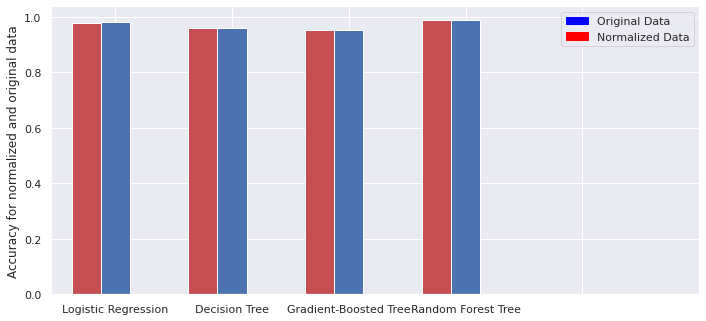

In [35]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_axes([0,0,1,1])

barWidth = 0.25

r1 = np.arange(4)
r2 = [x + barWidth for x in r1] 

predictions_list_normalized.append(accuracy_normalized)
predictions_list_original.append(accuracy_original)
langs = ['Logistic Regression','Decision Tree','Gradient-Boosted Tree', 'Random Forest Tree']

plt.bar(r1,predictions_list_normalized,color='r', width=barWidth )
plt.bar(r2,predictions_list_original,color='b', width=barWidth )
  
plt.ylabel('Accuracy for normalized and original data')
  
colors = {'Original Data':'blue', 'Normalized Data':'red'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.xticks([r + barWidth for r in range(0,6)], langs)

plt.show()

### 1) Normalized Data

For the model which is trained with **normalized data** , number of **true positive**, which is benign, is 59 and **true negative**, which is malignant, is 110, which mean that our model predicted all bening values in data and almost found all malignants except 2. 

In [36]:
predictions_normalized = predictions_normalized.withColumn("predictedLabel", F.col("predictedLabel").cast(DoubleType()))

from sklearn.metrics import confusion_matrix
y_true = predictions_normalized.select("label")
y_true = y_true.toPandas()

y_pred = predictions_normalized.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true["label"], y_pred["predictedLabel"])
cnf_matrix

array([[ 59,   0],
       [  2, 110]])

When we look at classification report for the model which is trained by normalized data, our recall for malignants 100%, which implies that we know 100% malignant data in all malignants, for being, we know 98% being data in all being. For precision values, all of the benings model said are true, for negative, 2% percent is not actually malignant. F1-score for positive is 99%, for negative is 98%, and for both class is %98.5 which is close to 100%. For positive and negative, F1-score is balanced which is important to take care of.

In [37]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98        59
         1.0       1.00      0.98      0.99       112

    accuracy                           0.99       171
   macro avg       0.98      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171



### 2) Original Data

For the model which is trained with **original data** , number of **true positive**, which is benign, is 59 and **true negative**, which is malignant, is 110 which our model predicted. All testing data is predicted which is bening and for malignant, just 2 of them are not be predicted.

In [38]:
predictions_original = predictions_original.withColumn("predictedLabel", F.col("predictedLabel").cast(DoubleType()))

from sklearn.metrics import confusion_matrix
y_true = predictions_original.select("label")
y_true = y_true.toPandas()

y_pred = predictions_original.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true["label"], y_pred["predictedLabel"])
cnf_matrix

array([[ 59,   0],
       [  2, 110]])

When we look at classification report for the model which is trained by original data, our recall for malignants 100%, which implies that we know 100% malignant data in all malignants, for being, we know 98% being data in all being. For recall values, the predict results of data about malignant. For precision values, all of the benings model said are true, for negative, 2% percent is not actually malignant. F1-score for positive is 99%, for negative is 98%, and for both class is %98.5 which is close to 100%.

In [39]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98        59
         1.0       1.00      0.98      0.99       112

    accuracy                           0.99       171
   macro avg       0.98      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171



## References<a class="anchor" id="references"></a>

Implementations and Usage of MLLib algorithm: https://spark.apache.org/docs/2.1.0/


**Disclaimer!** <font color='grey'>This notebook was prepared by Oktay Uğurlu as an assigment for the *BBM469 - Data Intensive Applications Laboratory* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8). 
</font>